In [54]:
""" Filter based on h3 hexagons mapped to polygons

aws emr add-steps --cluster-id <Your EMR cluster id> --steps Type=spark,Name=TestJob,Args=[--deploy-mode,cluster,--master,yarn,--conf,spark.yarn.submit.waitAppCompletion=true,s3a://your-source-bucket/code/pythonjob.py,s3a://your-source-bucket/data/data.csv,s3a://your-destination-bucket/test-output/],ActionOnFailure=CONTINUE
"""

from collections import namedtuple
import logging
import sys

from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import udf
from sedona.utils.adapter import Adapter
#from sedona.core.formatMapper.geojsonReader import GeoJsonReader
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.SpatialRDD import PointRDD, SpatialRDD, CircleRDD
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import JoinQuery
from sedona.core.enums import IndexType
from sedona.core.formatMapper.disc_utils import load_spatial_rdd_from_disc, GeoType
from sedona.core.formatMapper import WktReader


import pyproj

from geopy.distance import great_circle
import pandas as pd
import geopandas as gpd
import os

from datetime import timedelta, date, datetime
from statistics import *

from pyspark import SparkContext

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StructType,
    LongType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
    TimestampType,
    ArrayType
)
from pyspark.sql.functions import (
    from_utc_timestamp,
    to_utc_timestamp,
    dayofyear,
    col,
    unix_timestamp,
    monotonically_increasing_id,
    pandas_udf,
    PandasUDFType,
    col,
    asc,
    lit,
    countDistinct,
)
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorSlicer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import concat, lit, col, when
from pyspark.ml.linalg import VectorUDT, SparseVector, Vectors


from math import *
import time

from shapely.wkt import loads as wkt_loads
from shapely.geometry import Point, Polygon, shape
from shapely.ops import transform
import shapely

from matplotlib import pyplot as plt

spark = (SparkSession.builder.appName("sedona")
                 .config("spark.serializer", KryoSerializer.getName)          
        .config("spark.kryo.registrator",     
                  SedonaKryoRegistrator.getName)    
         .config("spark.driver.maxResultSize", "3g")
    .getOrCreate() 
        )


# Register Sedona UDTs and UDFs
SedonaRegistrator.registerAll(spark)

spark.sparkContext.addPyFile("s3://ipsos-dvd/scripts/utils.py")
from utils import *
import h3_pyspark as h3s
#import h3pandas 
import h3 as h3
import io



@udf("boolean")
def pip_filter(poly_wkt, point_x, point_y):
    from shapely import wkt
    from shapely import geometry
    polygon = wkt.loads(poly_wkt)
    point = geometry.Point(point_x, point_y)
    return polygon.contains(point)

schema = StructType([
    StructField("dirty", ArrayType(StringType()), False),
    StructField("hexes", ArrayType(StringType()), False)
])


def parse_dates(x):
    if "/" in x:
        start_date = datetime.strptime(x.split('/')[0], "%Y-%m-%d")
        end_date = datetime.strptime(x.split('/')[1], "%Y-%m-%d")
        delta = end_date - start_date
        date_list = []
        for i in range(delta.days + 1):
            date = start_date + timedelta(days = i)
            date_list.append(date.strftime("%Y/%m/%d"))
        return(date_list)
    else: 
        return([x.replace("-", "/")])
    
def create_point(longitude: float, latitude: float):
    return Point(longitude, latitude)

create_point_udf = udf(create_point, GeometryType())


def create_polygon(wkt: str):
    return wkt_loads(wkt)

create_polygon_udf = udf(create_polygon, GeometryType())

def transform_geometry(geom, crs_from = 'EPSG:4326', crs_to = 'EPSG:9311'):
    wgs84 = pyproj.CRS(crs_from)
    utm = pyproj.CRS(crs_to)

    project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

    # Ensure that the input geometry is a shapely geometry object
    if not isinstance(geom, (shapely.geometry.base.BaseGeometry, shapely.geometry.base.BaseMultipartGeometry)):
        geom = shape(geom)

    utm_point = transform(project, geom)
    
    return utm_point

transform_geometry_udf = udf(transform_geometry, GeometryType())


def shared_polygon(long, lat):
    return Point(long, lat).buffer(35)
shared_polygon_udf = udf(shared_polygon, GeometryType())

def buffer(geom, meters):
    return geom.buffer(meters)
buffer_udf = udf(buffer, GeometryType())

def parse_dates(x):
    if "/" in x:
        start_date = datetime.strptime(x.split('/')[0], "%Y-%m-%d")
        end_date = datetime.strptime(x.split('/')[1], "%Y-%m-%d")
        delta = end_date - start_date
        date_list = []
        for i in range(delta.days + 1):
            date = start_date + timedelta(days = i)
            date_list.append(date.strftime("%Y/%m/%d"))
        return(date_list)
    else: 
        return([x.replace("-", "/")])
    
def saveFigS3(fn, fig):
    
    # Create an s3 client
    s3 = boto3.resource('s3')

    # Set the bucket name and object name
    bucket = s3.Bucket('ipsos-dvd')

    img_data = io.BytesIO()
    fig.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    

    # Upload the plot to s3
    bucket.put_object(Body=img_data, ContentType='image/png', Key=fn)
    
def spatialIntersection(pings, poly, build_on_spatial_partitioned_rdd = True, using_index = True, origin_crs="epsg:4326", crs="epsg:4326", 
                        transform=True, poly_spatial=False): 
    
    if not poly_spatial:
        poly_rdd = Adapter.toSpatialRdd(poly, "geometry")
    else:
        poly_rdd = poly

    pings.createOrReplaceTempView("pings")

    # Read Hive table
    if transform:
        pings = spark.sql(
              f"""SELECT ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}") AS point, 
              *
              FROM pings;
              """
        )
    else:
        pings = spark.sql(
              f"""SELECT ST_FlipCoordinates(ST_Transform(ST_FlipCoordinates(ST_Point(pings.longitude, 
              pings.latitude)), "{origin_crs}", "{crs}")) AS point, 
              *
              FROM pings;
              """
        )
#     num_partitions = 1000
#     pings = pings.repartition(num_partitions)
#    pings = pings.cache()
    
    grid_type = GridType.QUADTREE # this shit works so much better for skewed data

    points_rdd = Adapter.toSpatialRdd(pings, "point")
    points_rdd.analyze()
    points_rdd.spatialPartitioning(grid_type)
    
    poly_rdd.analyze()
    poly_rdd.spatialPartitioning(points_rdd.getPartitioner())
    
     ## Set to TRUE only if run join query
    points_rdd.buildIndex(IndexType.QUADTREE, build_on_spatial_partitioned_rdd)
    
    result = JoinQueryRaw.SpatialJoinQueryFlat(points_rdd, poly_rdd, using_index, True)

    return Adapter.toDf(result, poly_rdd.fieldNames, points_rdd.fieldNames, spark)

    
essential_fields = [
        StructField("utc_timestamp",LongType(),False),
        StructField("caid",StringType(),False),
        StructField("latitude",DoubleType(),False),
        StructField("longitude",DoubleType(),False),
        StructField("altitude",DoubleType(),False),
]
raw_schema = StructType(
    essential_fields + [
        StructField("id_type",StringType(),False),
        StructField("geo_hash",StringType(),False),
        StructField("horizontal_accuracy",DoubleType(),False),
        StructField("ip_address",StringType(),False),
        #StructField("altitude",DoubleType(),False),
        StructField("iso_country_code",StringType(),False)]
)

#------
# parameters
#------

data_dir = "s3://external-safegraph/"
data_dyn = "s3://ipsos-dvd/dyn/data/"
figs_dir = "s3://ipsos-dvd/dyn/results/figs/"
data_veraset = "s3://external-veraset-data-us-west-2/us/"




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Construct Worker-Store Panel

In [ ]:
## grab workers' employment and home locations  

dwomes = spark.read.parquet(os.path.join(data_dyn, 'worker_homes')) # checked and no duplicates in placekey, caid, week combo

home_locations = spark.read.parquet( # no duplicates in here either
    os.path.join(data_dyn, 'homes_candidates_stores_cz'),inferSchema = True
).drop("leftgeometry", "rightgeometry", "fips_county") \
    .withColumnRenamed('latitude', 'latitude_home').withColumnRenamed('longitude', 'longitude_home') \
    .withColumnRenamed('cz', 'cz_home').withColumnRenamed('fips_cbg', 'fips_cbg_home')
    

dwomes = dwomes.join(home_locations, on = "caid", how = "inner")

## merge in places data
place = spark.read.parquet(data_dyn + "places_chains_filtered_cbgs") # some duplicates in here! 
place = place.dropDuplicates(subset=['placekey'])
dwomes = dwomes.join(place, on = "placekey", how="left")

# there are some devices that had a tie (visited different placekey same number of times), drop those
# TODO: in general I guess I want to drop devices that "work at" multiple stores in a given week
temp = dwomes.groupBy(['caid', 'week']).agg(F.count("count").alias("cnt")).filter(F.col("cnt") > 1)
dwomes = dwomes.join(temp, on = ['caid', 'week'], how = "leftanti")

dwomes = dwomes.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
redo_other_places = False
if redo_other_places: 
    # get the market for the non-chain stores
    # merge on CBG shapefiles
    cbgs = ShapefileReader.readToGeometryRDD(sc, data_dyn + "census_bg_merged/")
    cbgs = (Adapter.toDf(cbgs, cbgs.fieldNames, spark))

    # gpd.read_file("s3://ipsos-dvd/ev/data/2020_cbgs/*")

    cbgs = cbgs.repartition(1000)

    places = spark.read.parquet(os.path.join(data_dyn, "spend_places")).select("placekey", "latitude", "longitude")
    places = places.dropDuplicates(subset=['placekey'])

    places = places.join(place.select("placekey", "chain"), on = "placekey", how = "leftanti")


    # intersect remaining places with cbg
    joined = spatialIntersection(places, cbgs.select("geoid", "geometry").withColumnRenamed("geoid", "fips_cbg"), transform=False)

    # merge in commuting zones 
    cz = spark.read.csv(data_dyn + "geo/commuting_zones.csv", header=True)
    cz = cz.withColumnRenamed("FIPS", "fips_county").withColumnRenamed("Commuting Zone ID, 2000", "cz").select("fips_county", "cz")

    joined = joined.withColumn("fips_county", F.substring("fips_cbg", 1,5)).join(cz, on = "fips_county", how = "left")
    joined.write.parquet(data_dyn + "places_nonchains_cbg", mode="overwrite")
    
joined = spark.read.parquet(data_dyn + "places_nonchains_cbg", mode="overwrite").drop("rightgeometry", "fips_cbg",
                                                                                      "leftgeometry", "latitude", "longitude")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwomes = dwomes.join(joined.withColumnRenamed("cz", "cz_other").withColumnRenamed("fips_county", "fips_county_other"), on = "placekey", how="left")

# encode the outside option
dwomes = dwomes.withColumn("outside_option", F.when(F.col("cz").isNotNull(), F.lit(0)).otherwise(F.lit(1)))\
        .withColumn("cz_combined", F.when(F.col("outside_option") == 0, F.col("cz")).otherwise(F.col("cz_other")))\
        .withColumn("fips_county_combined", F.when(F.col("outside_option") == 0, F.col("fips_county")).otherwise(F.col("fips_county_other")))\
        .withColumn("placekey_chains", F.when(F.col("cz").isNotNull(), F.col("placekey")).otherwise(F.lit("outside-option"))) 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Convert week_year to quarter
dwomes = dwomes.withColumn(
    "year", F.col("week").substr(3, 5)  # Extract the year part
).withColumn(
    "week_simple", F.col("week").substr(1, 2).cast(IntegerType())  # Extract the week part
).withColumn(
    "first_day_of_year", 
    F.to_date(F.concat(F.col("year"), F.lpad(F.lit("1"), 2, "0"), F.lpad(F.lit("1"), 2, "0")), "yyyyMMdd")  # Construct the first day of the year
).withColumn(
    "target_week_date",
    F.expr("date_add(first_day_of_year, (week_simple - 1) * 7)")  # Calculate the date of the first day of the target week
).withColumn(
    "quarter", 
    F.quarter("target_week_date")  # Determine the quarter from the date
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# only use devices that are observed to choose the non-outside option in multiple weeks OR that choose the outside option
# NB there actually are devices that choose oo and also choose chains
temp = dwomes.groupby("caid").agg(F.count("week").alias("cnt_wk"), 
                                  F.sum((F.col("outside_option") == 1).cast(IntegerType())).alias("cnt_oo"), 
                                  F.countDistinct("placekey").alias("switchers"), 
                                 F.countDistinct("quarter").alias("quarters"))
# temp = temp.filter(( F.col("cnt_oo") == F.col("cnt_wk")) | ((F.col("cnt_wk") - F.col("cnt_oo")) >= 4)) # either JUST oo or oo AND at least 2 other visits
# temp = temp.filter(F.col("cnt_wk") >= 6)
# temp = 
# temp = temp.filter( ((F.col("cnt_wk") - F.col("cnt_oo")) >= 2)) # either JUST oo or oo AND at least 3 other visits
temp = temp.filter((F.col("quarters") == 2) & ((F.col("cnt_wk") - F.col("cnt_oo")) >= 4) | ((F.col("cnt_wk") == F.col("cnt_oo"))))

# only keep caids of dwomes that are in temp
dwomes = dwomes.join(temp.select("caid"), on = "caid", how = "inner")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwomes.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['caid', 'placekey', 'week', 'count', 'rank', 'fips_cbg_home', 'latitude_home', 'longitude_home', 'cz_home', 'fips_county', 'leftgeometry', 'fips_cbg', 'rightgeometry', 'parent_placekey', 'safegraph_brand_ids', 'location_name', 'brands', 'store_id', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours', 'category_tags', 'opened_on', 'closed_on', 'tracking_closed_since', 'websites', 'geometry_type', 'polygon_wkt', 'polygon_class', 'enclosed', 'phone_number', 'is_synthetic', 'includes_parking_lot', 'iso_country_code', 'wkt_area_sq_meters', 'chain', 'cz', 'fips_county_other', 'cz_other', 'outside_option', 'cz_combined', 'fips_county_combined', 'placekey_chains', 'year', 'week_simple', 'first_day_of_year', 'target_week_date', 'quarter']

In [ ]:
# filter out devices that aren't working in their home cz
dwomes = dwomes.withColumn("fips_county_home", F.substring("fips_cbg_home", 1,5))
dwomes = dwomes.filter((dwomes.fips_county_combined == dwomes.fips_county_home) | (dwomes.fips_county_combined.isNull()))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
## merge in wages
wages_chains = spark.read.parquet(data_dyn + "wagescape_chains_county")
wage_zip = (wages_chains.withColumn("quarter", F.quarter("POST_DATE"))
            .groupBy("chain", "quarter", "cz")
            .agg(F.percentile_approx("SALARY", 0.5).alias("SALARY")).fillna("NA")
           )

dwomes = dwomes.join(wage_zip, on = ['chain', "quarter", "cz"], how="left")

# dwomes = dwomes.filter(F.col("SALARY").isNotNull())

# # filter out markets where we don't have wages for all the chains
mkts = (dwomes.filter(F.col("placekey_chains").isNotNull()) # this is important cause I didnt collect salary data for non chains
        .groupby("cz").agg(F.avg(F.col("SALARY").isNull().cast(IntegerType())).alias("missing_wages"))
    ).withColumnRenamed("cz", "cz_combined")
# filter out market where more than 1% of salary observations are missing
mkts = mkts.filter(F.col("missing_wages") < 0.5) # TODO: need to revisit this, maybe use wages from neighboring markets or drop smaller chains
# now filter those out of ext_dwomes_wages
dwomes = dwomes.join(mkts.drop("missing_wages"), on = "cz_combined", how = "inner")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Step 1: Generate all possible caid-placekey combinations within each cz_home at a given month
# Get unique caids and placekeys within each cz_home
unique_caids = dwomes.select("caid", "fips_county_combined", "week", 'quarter')\
            .withColumnRenamed("fips_county_combined", "fips_county")\
            .distinct()
unique_placekeys = place.select("placekey", "fips_county") \
                    .filter(F.col("placekey").isNotNull() & F.col("fips_county").isNotNull()) \
                    .withColumnRenamed("placekey", "placekey_chains").distinct() # 

# # add outside-option for each market
new_rows_df = unique_placekeys.select("fips_county").distinct().withColumn("placekey_chains", F.lit("outside-option"))
unique_placekeys = unique_placekeys.unionByName(new_rows_df)

# Cross join unique_caids and unique_placekeys on cz_home and month to get all combinations
all_combinations = unique_caids.alias("a").join(
    unique_placekeys.alias("b"),
    ['fips_county'],
    "left"
).select(
    F.col("a.caid"),
    F.col("b.placekey_chains"),
    F.col("a.fips_county"),
    F.col("a.week"), 
    F.col("a.quarter")
)

# Step 2: Mark actual employment
# Join all_combinations with dwomes to find actual employment records
extended_dwomes = all_combinations.join(
    dwomes.select("caid", "placekey_chains", "week", "cz_combined"),  # select relevant columns to avoid duplicates
    on=["caid", "placekey_chains", "week"],
    how="left"
)

# Add pr_work column: 1 if the combination exists in dwomes, 0 otherwise
extended_dwomes = extended_dwomes.withColumn(
    "pr_work",
    F.when(F.col("cz_combined").isNotNull(), 1).otherwise(0) # using the cz column to check whether actually visited because it's never missing in dwomes. Caids with null placekeys (outside option) will have 0 everywhere
).drop("cz_combined")

# now merge in all the other information on the place
extended_dwomes = extended_dwomes.join(place.drop("fips_county"), on = extended_dwomes.placekey_chains == place.placekey, how="left") # left join because place df only includes chains

# merge home information back in
extended_dwomes = extended_dwomes.join(home_locations, on = "caid", how = "inner")

# and wage information 
extended_dwomes = extended_dwomes.join(wage_zip, on = ['chain', 'quarter', "cz"], how="left")

cols_keep = ['chain', 'quarter', 'cz', 'cz_combined', 'caid', 'placekey_chains', 'week', 'pr_work','fips_cbg', 'open_hours', 'includes_parking_lot', 
             'wkt_area_sq_meters', 'fips_cbg_home', 'cz_home', 'SALARY', 'latitude', 'longitude', 'latitude_home', 'longitude_home', ]

extended_dwomes.select(cols_keep).write.parquet(data_dyn + "extended_dwomes", mode="overwrite")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Regression Prep

In [62]:
extended_dwomes = spark.read.parquet(data_dyn + "extended_dwomes") \
                .select('cz_combined', "cz", 'chain', 'caid', 'week', 'pr_work', 'placekey_chains',
                        'open_hours', 'includes_parking_lot', 'latitude', 'longitude', 
                        'latitude_home', 'longitude_home', 'cz_home', 'SALARY', 'wkt_area_sq_meters') \
                    .withColumnRenamed("placekey_chains", "placekey") 
    # filter on columns to reduce data size

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
## this gives issues cause cz column not complete
# temp = extended_dwomes.groupby("cz").agg(F.countDistinct("caid")).toPandas()
# temp = temp[temp['count(caid)'] >= 100] 
# czs = list(temp['cz'])
# extended_dwomes = extended_dwomes.filter(F.col("cz").isin(czs))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
# balance number of outside-option only caids vs the rest
temp = extended_dwomes.filter(F.col("pr_work")==1)\
            .groupby("caid")\
            .agg(F.mean((F.col("placekey") == "outside-option").cast(IntegerType())).alias("cnt")).toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
oo = list(temp[temp.cnt == 1]['caid'])
option = list(temp[temp.cnt < 1]['caid'])
import random

smpl = 0.1
option = random.sample(option, round(smpl * len(option)))
poo = random.sample(oo, round(0.05 * len(option)))
caids_sample = option + poo

extended_dwomes = extended_dwomes.filter(F.col("caid").isin(caids_sample))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
extended_dwomes.agg(F.countDistinct("caid")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|count(caid)|
+-----------+
|       3284|
+-----------+

In [67]:
for col in ['latitude', 'longitude']:
    extended_dwomes = extended_dwomes.withColumn(col, F.when(F.col("placekey") == 'outside-option', F.lit(0)).otherwise(F.col(col)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# now prepare and run the logit regression
from pyspark.ml.classification import LogisticRegression

# calculate distance 

# function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    return 2*6378000*sqrt(pow(sin((lat2-lat1)/2),2) + cos(lat1)*cos(lat2)*pow(sin((lon2-lon1)/2),2)) # result in meters


dist_udf=udf(haversine, DoubleType())


extended_dwomes = extended_dwomes.withColumn('distance', (dist_udf(pi * F.col('latitude') / 180, pi * F.col('longitude') / 180, 
                                      pi * F.col('latitude_home') / 180, pi * F.col('longitude_home') / 180)) / 1000)\
                                .withColumn("distance_sq", F.col("distance")**2) #in km

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# calculate store employment
dwomes = spark.read.parquet(os.path.join(data_dyn, 'worker_homes'))
emp = dwomes.groupBy(['placekey', 'week']).agg(F.countDistinct("caid").alias("total_caids"))
# calculate conditional average across time periods
emp = emp.groupBy(['placekey']).agg(F.avg("total_caids").alias("total_caids"))
extended_dwomes = extended_dwomes.join(emp, on = ['placekey'], how = 'left')

extended_dwomes = extended_dwomes.withColumn("total_caids", 
                                             F.when(F.col("total_caids").isNull(),
                                                    0).otherwise(F.col("total_caids")))\
                        .withColumn("total_caids_sq", F.col("total_caids")**2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
# # Define the UDF
# import json
# def calculate_weekend_hours(open_hours_str):
#     open_hours = json.loads(open_hours_str)
#     weekend_hours = 0
#     # Loop through Saturday and Sunday
#     for day in ['Sat', 'Sun']:
#         if day in open_hours:
#             for period in open_hours[day]:
#                 start, end = period[0], period[1]
#                 start_hour, start_minute = map(int, start.split(':'))
#                 end_hour, end_minute = map(int, end.split(':'))
#                 weekend_hours += (end_hour - start_hour) + (end_minute - start_minute) / 60.0
#     return int(weekend_hours)

# # Register UDF
# calculate_weekend_hours_udf = udf(calculate_weekend_hours, IntegerType())

# # Apply the UDF to calculate weekend hours
# extended_dwomes = extended_dwomes.withColumn("weekend_hours", calculate_weekend_hours_udf(extended_dwomes["open_hours"]))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
# set outside option variables to 0
extended_dwomes = extended_dwomes.withColumn("wage_log", 
                                             F.when(F.col("placekey") == 'outside-option', 0).otherwise(F.log("SALARY")))\
                                .filter(F.col("wage_log").isNotNull()) # now filter out chain stores without salary info
extended_dwomes = extended_dwomes.withColumn("SALARY", F.col("SALARY") / 2000)
cols_other = ["distance", "distance_sq", "SALARY"]

for col in ['chain', 'week', 'wage_log', 'cz_combined'] + cols_other:
    extended_dwomes = extended_dwomes.withColumn(col, F.when(F.col("placekey") == 'outside-option', F.lit(0)).otherwise(F.col(col)))
    


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# # create individual wage coefficients

# # get vector of caids that don't only choose outside option
# oo = extended_dwomes.groupBy("caid").agg(F.sum(F.col("pr_work") * (F.col("placekey") != 
#                                                                    "outside-option").cast(IntegerType())).alias("nooo"))
# oo = oo.filter(F.col("nooo") > 0).select("caid").toPandas()                                  

# for caid in list(oo['caid']): 
#     extended_dwomes = extended_dwomes.withColumn("salary_" + caid, F.col("SALARY") * 
#                                                  (F.col("caid") == caid).cast(IntegerType()))
    
    
# Define a UDF that returns salary if the condition matches, otherwise returns 0 (or null)
def calculate_salary_for_caid(target_caid):
    def inner(salary, caid):
        if caid == target_caid:
            return salary
        else:
            return 0.0 # Or return None if you prefer nulls in non-matching rows
    return udf(inner, DoubleType())

oo = extended_dwomes.groupBy("caid").agg(F.sum(F.col("pr_work") * (F.col("placekey") != 
                                                                   "outside-option").cast(IntegerType())).alias("nooo"))
oo = oo.filter(F.col("nooo") > 0).select("caid").toPandas()   
distinct_caids = list(oo['caid'])

# Start with the base columns you want to retain
select_expr = [F.col(column_name) for column_name in extended_dwomes.columns]

# Add the dynamically generated columns for each caid
select_expr += [calculate_salary_for_caid(caid)(F.col("SALARY"), F.col("caid")).alias(f"salary_{caid}") for caid in distinct_caids]

# Apply the select expression
extended_dwomes = extended_dwomes.select(*select_expr)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
assert(extended_dwomes.agg(F.mean("pr_work")).collect()[0][0] > 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
assert(extended_dwomes.filter(F.col("placekey") == "outside-option").count() > 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
extended_dwomes.write.parquet(data_dyn + "dwomes_dense", mode="overwrite")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Fit Model in Statsmodels

In [76]:
temp = spark.read.parquet(data_dyn + "dwomes_dense")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
temp.repartition(1).write.csv(data_dyn + "dwomes_dense_csv", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
workers.to_csv(data_dyn + "dwomes_dense.csv", index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
workers = pd.read_csv(data_dyn + "dwomes_dense.csv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from statsmodels.discrete.conditional_models import ConditionalLogit

workers['strata'] = workers['caid'] + workers['week'].astype(str)

# create chain fixed effects
test = pd.concat([workers, pd.get_dummies(workers['chain'], prefix="chain_")])

allcols = workers.columns
endog_names = [x for x in allcols if "salary" in x or "chain_" in x]
endog_names = endog_names + ['distance', 'distance_sq']
exog_names = 'pr_work'

mdl = ConditionalLogit( # **kwargs are for LikelihoodModel Class
    endog = np.array(workers[exog_names]),
    exog = np.array(workers[endog_names]),
    groups = np.array(workers['strata'])
)

res = mdl.fit(method="lbfgs", display=True)

resdf = pd.DataFrame([(res.params[i], endog_names[i]) for i in range(len(endog_names))], columns = ['beta', 'name'])

resdf.to_csv(data_dyn + "clogit_out.csv", index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Older stuff

In [ ]:
## create dummies

def dummiesWithRef(df, ref = "0_0", inputCol = "chain_week", dropLast=False):
    # Step 1: Preprocess Data
    # Create a unique identifier for each 'chain-week' combination


    # First, convert 'date' into numeric indices
    inputIndex = inputCol + "_index"
    chainWeekIndexer = StringIndexer(inputCol=inputCol, outputCol=inputIndex).fit(df)
    df = chainWeekIndexer.transform(df)


    # Apply OneHotEncoder without dropping the last category
    inputVec = inputCol + "_vec"
    chainWeekEncoder = OneHotEncoder(inputCol=inputIndex, outputCol=inputVec, 
                                     dropLast=dropLast) # !! change if including outside option

    # Define a Pipeline that includes both the indexer and the encoder
    pipeline = Pipeline(stages=[chainWeekEncoder])

    # Fit the pipeline to the data
    pipelineModel = pipeline.fit(df)

    # Transform the data
    df = pipelineModel.transform(df)

    if not dropLast:
        # now reset the reference category to the outside option

        # Assuming you want to exclude the minimum label similar to the Scala code
        # First, get the array of labels from the StringIndexer, sorted by index
        labels = chainWeekIndexer.labels

        # Exclude the 0_0 label
        indexOfExcludedLabel = labels.index(ref)

        # Prepare the indices to keep (all except the index of the excluded label)
        indicesToKeep = list(range(len(labels)))
        indicesToKeep.remove(indexOfExcludedLabel)

        # Use VectorSlicer to select the indices
        slicer = VectorSlicer(inputCol=inputVec, outputCol=inputVec + "_reference", indices=indicesToKeep)

        # Transform to get the final DataFrame with selected features
        df = slicer.transform(df)

    return df, chainWeekIndexer

extended_dwomes = extended_dwomes.withColumn("chain_week", F.concat(F.col("chain"), F.lit("_"), F.col("week")))
extended_dwomes, chainWeekIndexer = dummiesWithRef(extended_dwomes.drop("chain_week_index", 
                                                                        "chain_week_vec_reference", 
                                                                        "chain_week_vec"), 
                                                   ref = "0_0", 
                                                   inputCol = "chain_week", dropLast=False)

# extended_dwomes, weekIndexer = dummiesWithRef(extended_dwomes.drop("chain_week_index", 
#                                                                         "chain_week_vec_reference", 
#                                                                         "chain_week_vec"), 
#                                                    ref = "0", 
#                                                    inputCol = "week")

# extended_dwomes, czIndexer = dummiesWithRef(extended_dwomes.drop("chain_week_index", 
#                                                                         "chain_week_vec_reference", 
#                                                                         "chain_week_vec"), 
#                                                    ref = "0", 
#                                                    inputCol = "cz")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# # generate choice-level dummies
# extended_dwomes = extended_dwomes.withColumn("cs_index", F.concat(F.col("caid"), F.col("week")))
# extended_dwomes, csIndexer = dummiesWithRef(extended_dwomes, ref = "outside-option", inputCol = "cs_index",
#                                                  dropLast=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# # generate store-level dummies
# inputCol = "placekey"
# extended_dwomes, placekeyIndexer = dummiesWithRef(extended_dwomes.drop("placekey_index",
#                                                   "placekey_vec", "placekey_vec_reference"), 
#                                                   ref = "outside-option", inputCol = inputCol,
#                                                  dropLast=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
extended_dwomes = extended_dwomes.withColumn("wkt_area_sq_meters", F.col("wkt_area_sq_meters").cast(LongType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Fit Model

In [ ]:

# Assume 'total_caids', 'total_caids_sq', and 'weekend_hours' are already in the DataFrame

# Step 2: Assemble Features
cols_other = ["distance", "distance_sq"]

# Assuming 'caid_salary' is your caid-specific salary column and already exists
featureCols =  cols_other + ["caid_salary", "cs_index_vec", "chain_week_vec_reference"] 
assembler = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")


# # Step 3: Train the Model
lr = LogisticRegression(featuresCol="features", labelCol="pr_work", fitIntercept=True,
                        standardization=True, maxIter=5000) #  GeneralizedLinearRegression(family="binomial", link="logit", featuresCol="features", labelCol="pr_work")

# Create the pipeline
pipeline = Pipeline(stages=[assembler, lr]) 

# Fit the pipeline to the training data
pipelineModel = pipeline.fit(extended_dwomes)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
cs_index_vec does not exist. Available: placekey, cz, chain, caid, week, pr_work, open_hours, includes_parking_lot, latitude, longitude, latitude_home, longitude_home, cz_home, SALARY, wkt_area_sq_meters, distance, distance_sq, total_caids, total_caids_sq, wage_log, caidIndex, caid_salary, chain_week, chain_week_index, chain_week_vec, chain_week_vec_reference, cs_index, placekey_index, placekey_vec, placekey_vec_reference
Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1710859788853_0005/container_1710859788853_0005_01_000001/pyspark.zip/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1710859788853_0005/container_1710859788853_0005_01_000001/pyspark.zip/pyspark/ml/pipeline.py", line 132, in _fit
    dataset = stage.transform(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1710859788853_0005/container_1710859788853_0005_01_000001/

In [ ]:
# extended_dwomes.filter(F.greatest(*[F.col(i).isNull() for i in cols_other])).select(cols_other + ['placekey']).show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Extract the Logistic Regression model from the fitted pipeline
glmModel = pipelineModel.stages[-1]

# Retrieve the coefficients
coefficients = glmModel.coefficients

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'pipelineModel' is not defined
Traceback (most recent call last):
NameError: name 'pipelineModel' is not defined



In [ ]:
# Objective history
summary = glmModel.summary

objectiveHistory = summary.objectiveHistory
print("Objective History:")
# for objective in objectiveHistory:
#     print(objective)

# Check for convergence by examining the reduction in objective function value
if len(objectiveHistory) < lr.getMaxIter() and abs(objectiveHistory[-1] - objectiveHistory[-2]) < lr.getTol():
    print("Model likely converged.")
else:
    print("Model may not have converged.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'glmModel' is not defined
Traceback (most recent call last):
NameError: name 'glmModel' is not defined



In [ ]:
cols_other = ["distance", "distance_sq"]
coefficients_labels = cols_other + ['salary_' + caid for caid in model_caids.labels] +csIndexer.labels # + chainWeekIndexer.labels + placekeyIndexer.labels


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
coefficientsMapping = [(coefficients_labels[i], coefficients[i]) for i in range(len(coefficients))]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
coeffs = pd.DataFrame(coefficientsMapping, columns = ['name', 'beta'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
coeffs[coeffs.name.str.contains("salary")]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                  name      beta
2    salary_bae3e332ed8194117fd4bb2d44913d7b932c376... -0.150854
3    salary_f545f25950a0ad02dd4b516eb0fecfa8c40d5c6... -0.199497
4    salary_4d6082621266178b35772d13fc725b7d639dbf6...  0.078731
5    salary_9b3942a5d88a1a847e47096881ddc74d220287e...  0.058730
6    salary_ca4c1bfb518650077c1ce82aac50c50bd2eb555... -0.573626
..                                                 ...       ...
650  salary_3a71d902f989953d6b3d55087caf6ab7fc396b4... -0.351000
651  salary_c44171c5538c839556b2a35f405317a19422237... -0.380415
652  salary_34959dfe163dda68f4039b32884e3b2cd3116a7... -0.177261
653  salary_6e5ab2ee3c29b7688dcc423f556d8f0b41e8ab1... -0.172911
654  salary_250a6cfcd02347701659d761a8223d396ed41da... -0.136042

[653 rows x 2 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

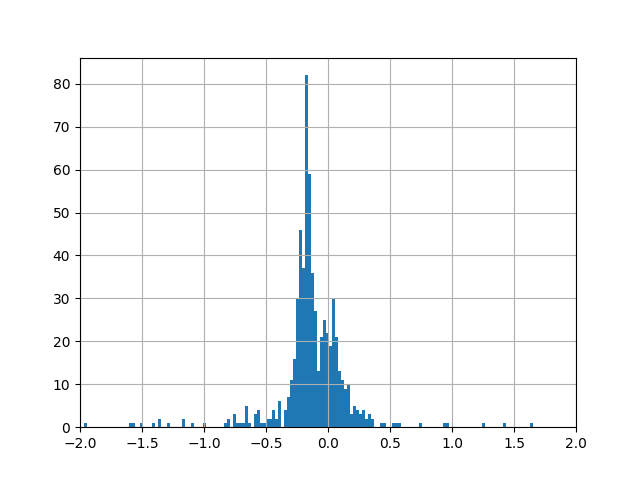

In [ ]:
# NB the distribution is bimodal with negative wage coefficients when I have week-chain fixed effects and I have no idea why
fig, ax = plt.subplots(1,1)
coeffs[coeffs.name.str.contains('salary')]['beta'].hist(bins = 1000, ax=ax)
plt.xlim(-2,2)
%matplot plt

In [ ]:
 extended_dwomes.select("cz").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+
| cz|
+---+
|356|
|583|
| 54|
|151|
|196|
|349|
|284|
|214|
|144|
| 31|
|230|
|566|
|625|
|436|
|127|
|640|
| 83|
|185|
|465|
|637|
+---+
only showing top 20 rows

In [ ]:
# check what caids the coefficients belong to
coeffs = coeffs[coeffs.name.str.contains("salary")]
coeffs['caid'] = coeffs['name'].str.split("_").str[-1]
coeffs.drop('name', axis=1, inplace=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
coeffs.to_csv(data_dyn +"coeffs_inspect.csv")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
coeffs = pd.read_csv(data_dyn + "coeffs_inspect.csv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
temp = spark.read.csv(data_dyn + "coeffs_inspect.csv", header=True)
waza = extended_dwomes.join(temp, on = ['caid'], how = 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
waza = waza.groupBy(['caid']).agg(F.avg("cz").alias("cz"), F.avg("beta").alias("beta"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
waza = waza.groupBy(['caid']).agg(F.sum(((F.col("placekey") == 'outside-option') & 
                                         (F.col("pr_work") == 1)).cast(IntegerType())).alias("cnt"), F.avg("beta").alias("beta"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# waza.filter((F.col("beta") > 0)).agg(F.avg((F.col("placekey") == "outside-option").cast(IntegerType()))).show()
waza.filter(F.col("beta") > 0).agg(F.avg("cnt")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|          avg(cnt)|
+------------------+
|0.9501096612685261|
+------------------+

In [ ]:
# waza.filter((F.col("beta") < -0.5) & 
# (F.col("pr_work") == 1)).agg(F.avg(F.col("pr_work") * (F.col("placekey") == "outside-option").cast(IntegerType()))).show()

waza.filter(F.col("beta") < -0.5).agg(F.avg("cnt")).show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|          avg(cnt)|
+------------------+
|1.1446198432388521|
+------------------+

## Test Conditional Likelihood Implementation